In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
from datasets.data_utils import MBIBDataLoader
from Dbias.bias_classification import *


# !pip3 install https://huggingface.co/d4data/en_pipeline/resolve/main/en_pipeline-any-py3-none-any.whl

c:\Users\Yeshwanth Somu\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at d4data/bias-detection-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [2]:


# print("------------Processing-datasets------------")
# datasets_path = './datasets'
# data_dirs = [ name for name in os.listdir(datasets_path) if os.path.isdir(os.path.join(datasets_path, name))]
# for d in data_dirs:
#     if "pycache" in d or 'mbib' in d:
#         continue
#     subprocess.call("python " + os.path.join(datasets_path,d,'process.py'),shell=True)
# print("------------datasets-processed------------")
# print("------------creating-mbib------------")
# dl = MBIBDataLoader()
# dl.create_all_categories()

In [3]:
file_bias_map = {"cognitive-bias.csv":"Cognitive Bias", "fake-news.csv": "Fake News", "gender-bias.csv": "Gender Bias", "hate-speech.csv": "Hate Speech",
                "linguistic-bias.csv": "Linguistic Bias", "political-bias.csv": "Political Bias", "racial-bias.csv": "Racial Bias", "text-level-bias.csv": "Text Level Bias"}

full_data = []
for i in os.listdir("datasets/mbib-aggregated/"):
    data = pd.read_csv("datasets/mbib-aggregated/"+i)
    data['bias_type'] = file_bias_map[i]
    full_data.append(data)

full_data = pd.concat(full_data)
full_data.loc[~full_data.label.astype(bool), "bias_type"] = "Unbiased" # converting all non-labeled pieces of text to "Unbiased"

full_data = full_data.reset_index().drop(columns="index")

full_data["biased"] = full_data["bias_type"] != "Unbiased"
full_data.head()

,id,text,label,dataset_id,bias_type,biased
0,072-9268,To vote in Mexico every eligible Mexican citiz...,0,72,Unbiased,False
1,072-6808,Marco Rubio made it clear Not only does he thi...,0,72,Unbiased,False
2,072-5150,Ben Carson is running for president to elimina...,0,72,Unbiased,False
3,072-11817,There are literally teachers now who are getti...,0,72,Unbiased,False
4,072-7176,Leticia Van de Putte voted to stop schools fro...,0,72,Unbiased,False


In [10]:
import sys
def bias_classifier(x):
    try:
        return classifier(x)
    except:
        return [{"label":"Error"}]

def repeat_classifier_on_subset(full_data = full_data, size=.2):

    # getting sample of full_data with representative proportions of the "biased" column
    sample_size = size * len(full_data)  # 30% of the original dataset size
    mini = full_data.groupby("biased").sample(int(sample_size / 2), replace=True)

    # running the bias_classifier() on text in this sample, since it takes 500+ mins to run on the entire full_data df
    mini["output"] = mini["text"].agg(lambda x: bias_classifier(x))
    mini["pred_label"] = mini["output"].apply(lambda x: x[0]["label"])
    # mini["pred_score"] = mini["output"].apply(lambda x: x[0]["score"])
    mini["pred_label"] = mini["pred_label"] == "Biased"
    conf_matrix = pd.crosstab(mini["pred_label"], mini["biased"])

    return mini, conf_matrix

In [11]:
sample_size = .2 * len(full_data) 
mini = full_data.groupby("biased").sample(int(sample_size / 2), replace=True)

# running the bias_classifier() on text in this sample, since it takes 500+ mins to run on the entire full_data df
mini["output"] = mini["text"].agg(lambda x: bias_classifier(x))
mini["pred_label"] = mini["output"].apply(lambda x: x[0]["label"])
# mini["pred_score"] = mini["output"].apply(lambda x: x[0]["score"])
mini["pred_label"] = mini["pred_label"] == "Biased"
conf_matrix = pd.crosstab(mini["pred_label"], mini["biased"])

In [12]:
conf_matrix

biased,False,True
pred_label,,
False,22828,19491
True,26866,30203


In [17]:
pd.crosstab(mini["pred_label"], mini["biased"], normalize="index")

biased,False,True
pred_label,,
False,0.539427,0.460573
True,0.470763,0.529237


In [14]:
%%time
sample_size = .2 * len(full_data) 
mini2 = full_data.groupby("biased").sample(int(sample_size / 2), replace=True)

# running the bias_classifier() on text in this sample, since it takes 500+ mins to run on the entire full_data df
mini2["output"] = mini2["text"].agg(lambda x: bias_classifier(x))
mini2["pred_label"] = mini2["output"].apply(lambda x: x[0]["label"])
mini2["pred_label"] = mini2["pred_label"] == "Biased"
conf_matrix2 = pd.crosstab(mini2["pred_label"], mini2["biased"])
conf_matrix2

CPU times: total: 8h 3min 44s
Wall time: 2h 48min 46s


biased,False,True
pred_label,,
False,22943,19325
True,26751,30369


In [18]:
pd.crosstab(mini2["pred_label"], mini2["biased"], normalize="index")

biased,False,True
pred_label,,
False,0.542798,0.457202
True,0.468330,0.531670


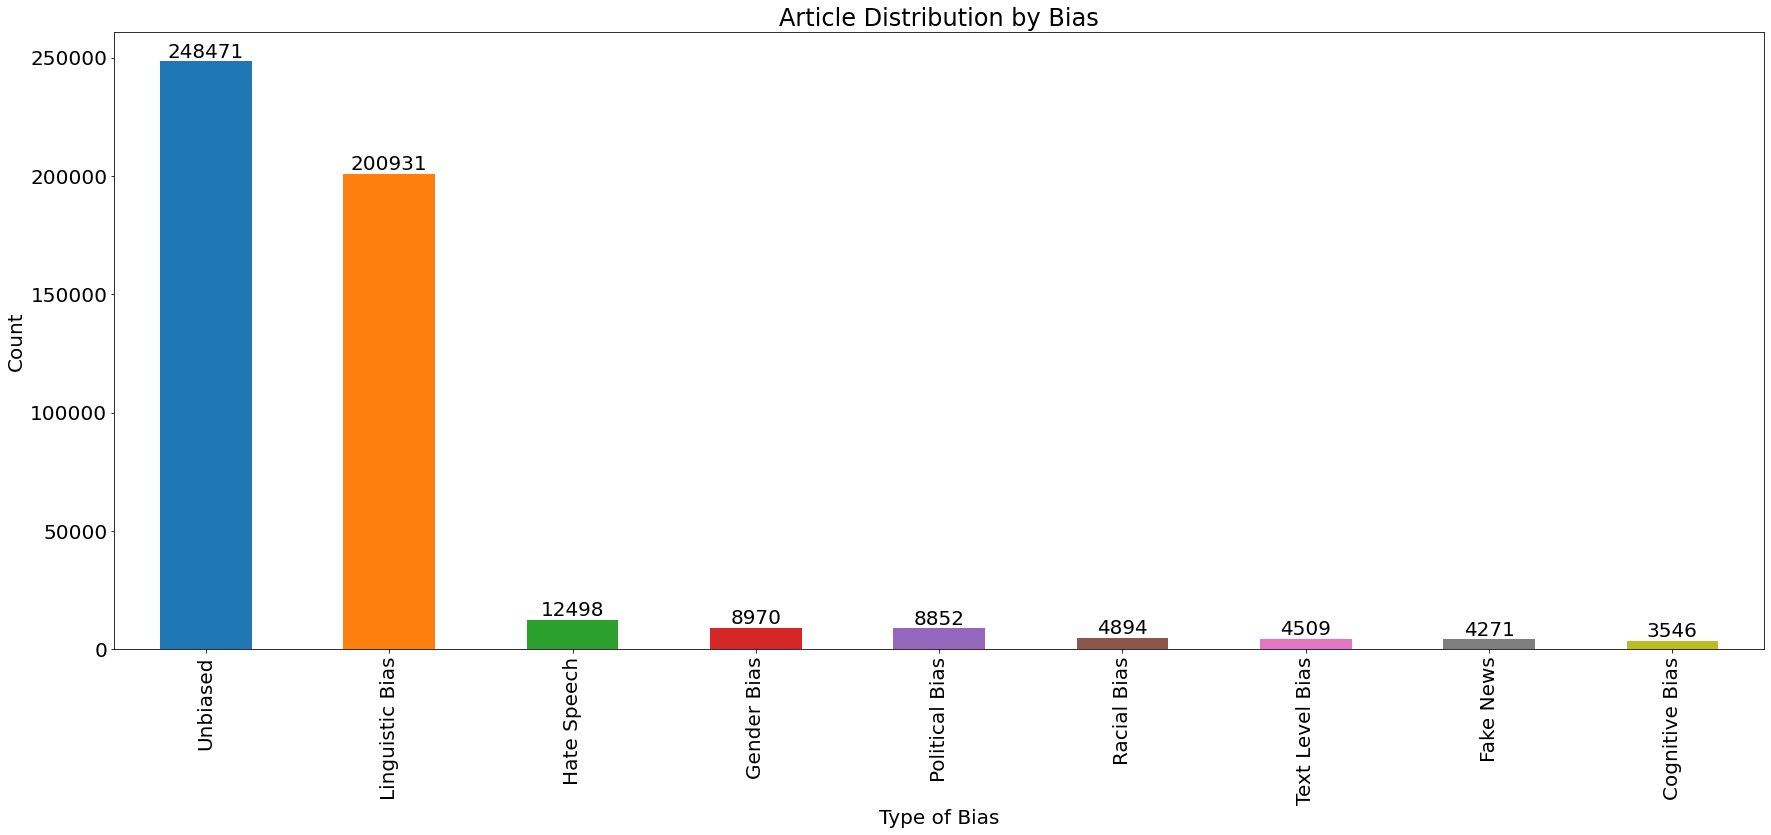

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(25,12))
ax = full_data.bias_type.value_counts().plot(kind="bar", title="Article Distribution by Bias", color=colors, ylabel="Count", xlabel="Type of Bias")
ax.bar_label(ax.containers[0], label_type='edge')
plt.tight_layout()